## 1. Backscatter - remote sensing in the ocean
<p><img align="right" width="400" height="1000" src="https://s3.amazonaws.com/assets.datacamp.com/production/project_547/img/4167340394_cc0b979fac_b_crop.jpg"> </p>
<p>Reflections. No, I’m not talking about contemplating your existence within the Tidyverse or understanding
what that spline did to your data. I’m talking about echoes. Specifically, sound echoes called “backscatter”. Marine scientists use backscatter to understand the distribution of organisms in the ocean.</p>
<p>In this analysis, we are going to wrangle active acoustic data and plot the mean volume backscatter associated with fish with swim-bladders in relation to bathymetry (depth of the sea floor).</p>
<p>For many marine ecologists, the goal of using active acoustic technologies is to extract biologically relevant quantities from backscatter. What are “biologically relevant quantities,” you ask? Great question! These are data that help us answer the <em>who</em>, <em>what</em>, <em>why</em>, <em>where</em>, <em>when</em>, and <em>how</em> in ecology.</p>
<p>Since World War II, the use of echosounders has allowed scientists to locate and visualize distributions of fish and zooplankton. Echosounders produce sound signals (pings) at specific frequencies and durations that are transmitted into the ocean. When these signals encounter something with a different density than the surrounding water, the signal is reflected back in the direction it came from. Thus, “backscatter”. Backscatter is recorded by the echosounder and useful information is calculated from the received signal, including the position of the source of the scattering (<em>“where”?</em>) and the intensity of the backscatter in decibels (dB) (broadly speaking, the <em>“who/what”?</em>). Active acoustic technologies are a unique remote sensing tool that allows scientists to take an acoustic “snap-shot” of a 3-dimensional environment.   </p>
<p>These acoustic data were collected from a research vessel that crossed the shelf break in the Mid-Atlantic Bight (<a href="https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ngdc.mgg.wcd:HB1103_EK60">NOAA cruise HB1103</a>) and were preprocessed using the proprietary software, <a href="https://www.echoview.com/">Echoview</a>. </p>

In [176]:
# Load the libraries
# .... YOUR CODE FOR TASK 1 ....
library(tidyverse)
library(lubridate)
library(geosphere)
library(gridExtra)
# Read in the depth data
bottom <- read_csv("datasets/bottom_line.csv", col_types = cols(Ping_date = col_date(format = "%m/%d/%Y")))

# Inspect the first six rows
# .... YOUR CODE FOR TASK 1 ....
head(bottom)

Ping_date,Ping_time,Ping_milliseconds,Latitude,Longitude,Position_status,Depth,Line_status,Ping_status,Altitude
2011-06-18,09:53:37,725,999.00000,999.00000,4,68.60377,1,0,-9.9e+37
2011-06-18,09:53:42,741,38.29771,-74.00185,3,68.60024,1,0,0.0e+00
2011-06-18,09:58:47,866,38.29429,-73.99677,1,68.78515,1,0,0.0e+00
2011-06-18,09:58:52,866,38.29424,-73.99666,1,68.77859,1,0,0.0e+00
2011-06-18,09:58:57,866,38.29418,-73.99653,1,68.37986,1,0,0.0e+00
2011-06-18,09:59:02,866,38.29411,-73.99641,1,68.37986,1,0,0.0e+00


## 2. What is the "shelf break"?
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_547/img/map_trkln.png" alt="map_trkln"></p>
<p>The red line in the map above is the ship's track across the shelf break in the Mid-Atlantic Bight. But what is the "shelf break"? The shelf break is the submerged edge of the continental shelf and it is characterized by a steep increase in slope gradients. It’s “The Big Drop-off”. In most marine ecosystems the shelf break is also a highly dynamic and productive area that provides a wide range of habitat for many marine species. The smallest phytoplankton to the largest marine mammals, sharks, seabirds, tunas, and sea turtles - they all utilize this area at some point in their life cycles. And, we’re going to play with some active acoustic data from this amazing region!</p>
<p>But first, let's clean up the bathymetry (depth) data and get it ready for plotting.</p>

In [178]:
# Clean the bottom data
bottom_clean <- bottom %>%
  # .... YOUR CODE FOR TASK 2 ....
  # .... YOUR CODE FOR TASK 2 ....
    filter(Position_status == 1) %>%
    select(Ping_date,Ping_time,Latitude,Longitude,Depth) %>%
  mutate(DT = ymd_hms(paste(Ping_date, Ping_time)),
       dist = c(0,distHaversine(cbind(Longitude[-n()], Latitude[-n()]),
                                cbind(Longitude[ -1], Latitude[ -1]))),                         
       distalong = cumsum(dist),
       t_diff = c(NA, difftime(DT[ -1], DT[-n()], units = "secs")),
       m_per_sec = dist/t_diff)
  
# Inspect the first six rows
# .... YOUR CODE FOR TASK 2 ....
head(bottom_clean)

Ping_date,Ping_time,Latitude,Longitude,Depth,DT,dist,distalong,t_diff,m_per_sec
2011-06-18,09:58:47,38.29429,-73.99677,68.78515,2011-06-18 09:58:47,0.00000,0.00000,NA,NA
2011-06-18,09:58:52,38.29424,-73.99666,68.77859,2011-06-18 09:58:52,11.47956,11.47956,5,2.295913
2011-06-18,09:58:57,38.29418,-73.99653,68.37986,2011-06-18 09:58:57,12.77948,24.25904,5,2.555895
2011-06-18,09:59:02,38.29411,-73.99641,68.37986,2011-06-18 09:59:02,13.24406,37.50310,5,2.648813
2011-06-18,09:59:07,38.29404,-73.99627,68.37986,2011-06-18 09:59:07,14.17050,51.67360,5,2.834099
2011-06-18,09:59:12,38.29396,-73.99612,68.38039,2011-06-18 09:59:12,15.34577,67.01937,5,3.069153


## 3. Where ever you go, there you are
<p>Now that we have removed the bad data points and calculated the cumulative distance the ship traveled, let's plot the data to see if our calculation makes sense. A horizontal view of the ship's track will show us if the ship deviated from the track line or if there were any breaks in the data. A plot of the depth of the sea floor along the track line will show us the position of the shelf break. In a spatial analysis of the track line data, we would normally work in the packages <code>sp</code> and <code>sf</code>, but that's a topic all its own. For now, we'll do a couple track line plots with the latitude, longitude, depth, and distance along the track line.</p>

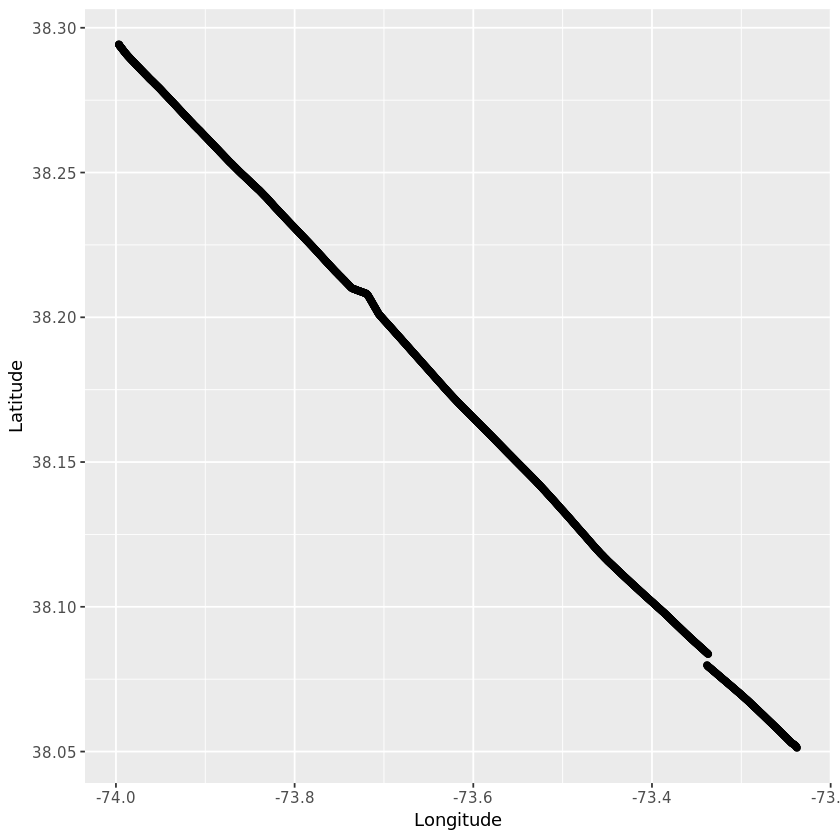

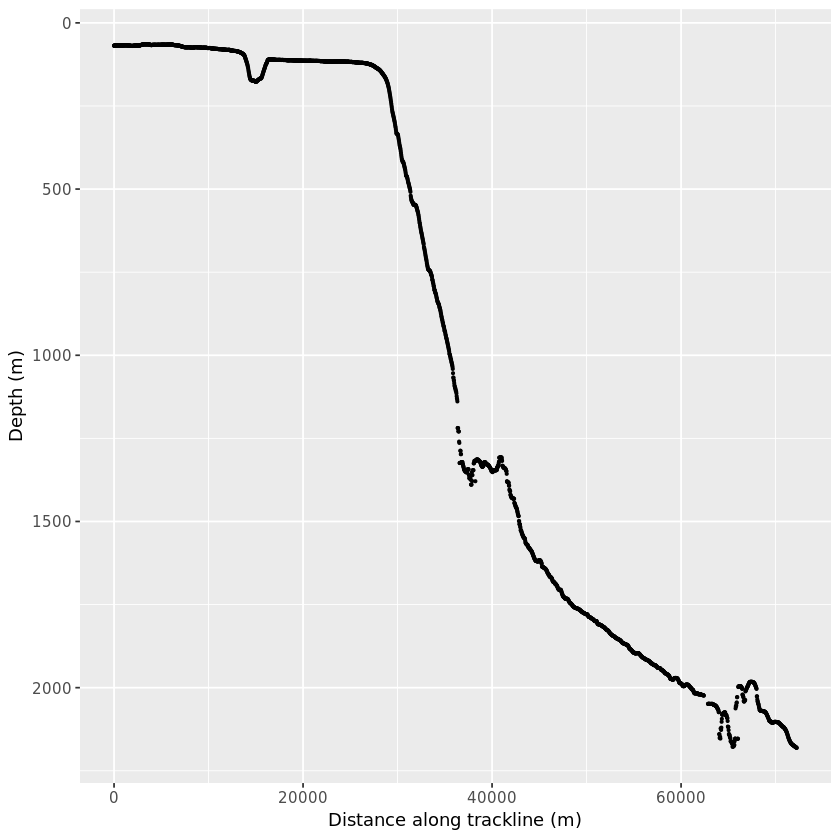

In [180]:
# Plot a horizontal view of the ship's track line
# .... YOUR CODE FOR TASK 3 ....
p_LonLat<-ggplot(bottom_clean,aes(x=Longitude,y=Latitude)) + geom_point() 

# View the plot
p_LonLat

# Plot the depth of the sea floor along the track line
# .... YOUR CODE FOR TASK 3 ....
p_bthy<-ggplot(bottom_clean,aes(x=distalong,y=Depth)) + geom_point(size=0.5) + scale_y_reverse() + labs(x = "Distance along trackline (m)", y = "Depth (m)")
# View the plot
p_bthy

## 4. What's the difference?
<p>It looks like the straight track line isn't so straight. Actually, this happens quite often with data collected in this area. There is a lot of fishing gear in the shelf break region of the Mid-Atlantic Bight and sometimes the ship must divert from the track line to avoid it. It is also possible that the GPS signal was lost for a few minutes. Let's find out what the difference is between the straight-line length of the track line (start point to endpoint) and the cumulative distance the ship traveled.</p>
<p>Calculating the difference between the cumulative meters traveled and the straight-line distance of the track line is a common task - a perfect time to create a function to use on other track line data files!</p>

In [182]:
# Create a function to calculate the difference between the cumulative distance the ship traveled 
# and the start and end points of the track line.
distance_diff <- function(bottom_data){
  cumulative_dist <- last(bottom_data$distalong)
  start <- cbind(first(bottom_data$Longitude), first(bottom_data$Latitude))
  end <- cbind(last(bottom_data$Longitude), last(bottom_data$Latitude))
  straight_line_dist <-  distHaversine(start, end)
  return(round(cumulative_dist - straight_line_dist, 1))
}

# Run the `distance_diff` on `bottom_clean`
# .... YOUR CODE FOR TASK 4 ....
distance_diff(bottom_clean)

[1] 513.3

## 5. Here fishy, fishy, fishy...
<p>In the grand scheme of track line diversions, a 513-meter difference isn't too bad. This difference could play a larger or small role in the data analysis depending on the ecological question being asked. For now, we'll keep it in mind as we load, clean, and plot out the acoustic data.</p>
<p>Volume backscatter is the summation of all the returned echoes within the sampling volume. It's a measure of the relative density of organisms. In this case, because we preprocessed the data in <a href="https://www.echoview.com/">Echoview</a> to look for fish-like scattering, our final plot of the volume backscatter data, <code>Sv_mean</code>, will give us an indication of how fish are distributed along the track line.</p>

Parsed with column specification:
cols(
  .default = col_integer(),
  Sv_mean = col_double(),
  NASC = col_double(),
  Sv_max = col_double(),
  Sv_min = col_double(),
  Sv_noise = col_double(),
  Height_mean = col_double(),
  Depth_mean = col_double(),
  Dist_S = col_double(),
  Dist_E = col_double(),
  Dist_M = col_double(),
  VL_start = col_double(),
  VL_end = col_double(),
  VL_mid = col_double(),
  Time_S = col_time(format = ""),
  Time_E = col_time(format = ""),
  Time_M = col_time(format = ""),
  Lat_S = col_double(),
  Lon_S = col_double(),
  Lat_E = col_double(),
  Lon_E = col_double()
  # ... with 18 more columns
)
See spec(...) for full column specifications.


Observations: 726
Variables: 78
$ Process_ID                           <int> 20216, 20216, 20216, 20216, 20...
$ Interval                             <int> 1, 4, 5, 6, 7, 8, 9, 10, 11, 1...
$ Layer                                <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ Sv_mean                              <dbl> -67.80649, -67.97805, -67.6505...
$ NASC                                 <dbl> 210.7003, 365.6001, 429.4046, ...
$ Sv_max                               <dbl> -56.94744, -53.93325, -54.5139...
$ Sv_min                               <dbl> -77.73801, -88.67275, -87.3610...
$ Sv_noise                             <dbl> -968.8756, -967.8684, -967.643...
$ NASC_noise                           <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ Height_mean                          <dbl> 29.50000, 53.25000, 58.00000, ...
$ Depth_mean                           <dbl> 39.50000, 39.04617, 39.00000, ...
$ Good_samples                         <int> 59, 639, 522, 464, 464, 406, 4...
$ Layer_depth_min   

Process_ID,Interval,Layer,Sv_mean,NASC,Sv_max,Sv_min,Sv_noise,NASC_noise,Height_mean,...,Layer_bottom_to_reference_line_range,Exclude_below_line_depth_min,Exclude_below_line_range_min,Exclude_below_line_depth_max,Exclude_below_line_range_max,Samples_Below_Bottom_Exclusion,Samples_Above_Surface_Exclusion,Samples_In_Domain,Bad_data_empty_water_samples,C_bad_data_empty_water_samples
20216,1,1,-67.80649,210.7003,-56.94744,-77.73801,-968.8756,0,29.5,...,244,68.60024,62.60024,68.60377,62.60377,362,8,488,0,0


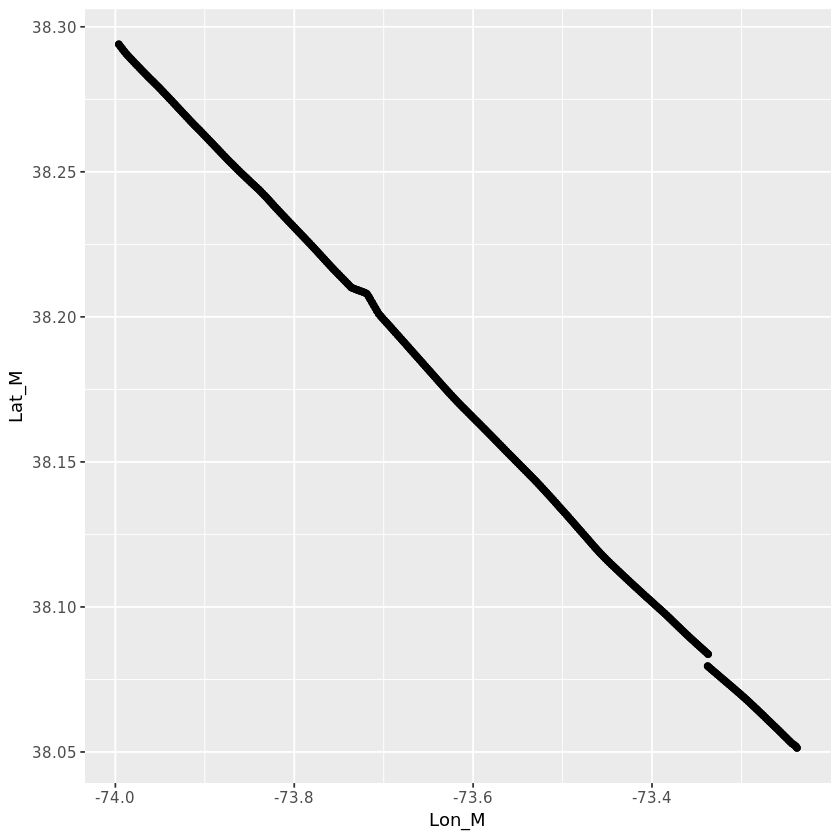

In [184]:
# Read in the acoustic data
acoustic <- read_csv("datasets/acoustic_LgSBF.csv")

# Glimpse the data
# .... YOUR CODE FOR TASK 5 ....
glimpse(acoustic)
head(acoustic,1)
# Remove bad positional data
acoustic_clean <- acoustic %>%
  # .... YOUR CODE HERE FOR TASK 5 ....
filter(Lon_M != 999.0)
# Plot a horizontal view of the ship's track line from the acoustic data
# .... YOUR CODE FOR TASK 5 ....
ggplot(acoustic_clean,aes(x=Lon_M,y=Lat_M)) + geom_point()

## 6. That's a lot of variables!
<p><strong>Wow! 726 observations of 78 variables!</strong> This is the full data export from Echoview, but remember, we’re only interested in the volume backscatter data, <code>Sv_mean</code>, and the few other variables needed to plot the data. </p>
<p>These backscatter data were integrated into grid cells that are 200 meters along the ship’s path, <code>Interval</code>, by 250 meters deep, <code>Layer</code>, making a coordinate system referenced to the ship’s path and depth. We are going to explore the first depth layer. </p>

In [186]:
# Create a list of variables to keep
vars_keep <- c("Interval", "Layer", "Sv_mean", "Frequency", 
               "Date_M", "Time_S", "Time_E", "Lat_M", "Lon_M")

# Select and filter the data 
Sv_sbf_layer1 <- acoustic_clean %>%
    select(one_of(vars_keep)) %>% 
    rename(intvr_along = Interval) %>%
    filter(Layer == 1)  %>% 
    mutate(DT_S = ymd_hms(paste(ymd(Date_M),Time_S)),
         DT_E = ymd_hms(paste(ymd(Date_M),Time_E))) %>% 
    arrange(DT_S) 

# Glimpse the cleaned acoustic data
# .... YOUR CODE FOR TASK 6 ....
glimpse(Sv_sbf_layer1)

Observations: 362
Variables: 11
$ intvr_along <int> 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1...
$ Layer       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...
$ Sv_mean     <dbl> -67.97805, -67.65053, -66.65866, -68.24425, -69.02423, ...
$ Frequency   <int> 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,...
$ Date_M      <int> 20110618, 20110618, 20110618, 20110618, 20110618, 20110...
$ Time_S      <time> 09:58:47, 09:59:47, 10:00:32, 10:01:12, 10:01:52, 10:0...
$ Time_E      <time> 09:59:42, 10:00:27, 10:01:07, 10:01:47, 10:02:22, 10:0...
$ Lat_M       <dbl> 38.29396, 38.29309, 38.29230, 38.29147, 38.29067, 38.29...
$ Lon_M       <dbl> -73.99612, -73.99397, -73.99202, -73.98992, -73.98776, ...
$ DT_S        <dttm> 2011-06-18 09:58:47, 2011-06-18 09:59:47, 2011-06-18 1...
$ DT_E        <dttm> 2011-06-18 09:59:42, 2011-06-18 10:00:27, 2011-06-18 1...


## 7. A little more wrangling
<p>Great! All this is coming together nicely. In <code>bottom_clean</code> we have depth, distance along the track line, and timestamps. We now also have an almost clean acoustic dataset, <code>Sv_sbf_layer1</code>, with timestamps but no distance along the track line, and no depth information (we'll get to that in a minute). Also, <a href="https://www.echoview.com/">Echoview</a> uses -999.0 to indicate NAs. We need to fix that or our plot will look a little wonky. </p>

In [188]:
# More data wrangling...
Sv_sbf <- Sv_sbf_layer1 %>% 
  mutate(dist_M = c(0, distHaversine(cbind(Lon_M[-n()], Lat_M[-n()]),       
                          cbind(Lon_M[  -1], Lat_M[  -1]))),
       distalong = cumsum(dist_M)) %>%
  na_if(-999.00) %>% 
  mutate(intvr = interval(DT_S, DT_E))

# Glimpse the data
# .... YOUR CODE FOR TASK 7 ....
glimpse(Sv_sbf)

Observations: 362
Variables: 14
$ intvr_along <int> 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1...
$ Layer       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...
$ Sv_mean     <dbl> -67.97805, -67.65053, -66.65866, -68.24425, -69.02423, ...
$ Frequency   <int> 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,...
$ Date_M      <int> 20110618, 20110618, 20110618, 20110618, 20110618, 20110...
$ Time_S      <time> 09:58:47, 09:59:47, 10:00:32, 10:01:12, 10:01:52, 10:0...
$ Time_E      <time> 09:59:42, 10:00:27, 10:01:07, 10:01:47, 10:02:22, 10:0...
$ Lat_M       <dbl> 38.29396, 38.29309, 38.29230, 38.29147, 38.29067, 38.29...
$ Lon_M       <dbl> -73.99612, -73.99397, -73.99202, -73.98992, -73.98776, ...
$ DT_S        <dttm> 2011-06-18 09:58:47, 2011-06-18 09:59:47, 2011-06-18 1...
$ DT_E        <dttm> 2011-06-18 09:59:42, 2011-06-18 10:00:27, 2011-06-18 1...
$ dist_M      <dbl> 0.0000, 211.7871, 192.3324, 204.8778, 209.1278, 183.363...
$ distalong   <dbl> 

## 8. Can't go spatial? Go temporal
<p>There is no depth information in the acoustic file. Well, that's not exactly true. One of those 76 variables was a mean depth, but it was an average of an average and it was not as accurate as the depth data we have in <code>bottom_clean</code>. </p>
<p>You might have also noticed that the two data sets have different spatial resolutions. How can we pull the depth data out of <code>bottom_clean</code> and join it with the acoustic data? There are a few different spatial ways to do this, but because we are not working in the spatial packages, we'll write our own function to determine which data points from <code>bottom_clean</code> fall within each along-track <code>Interval</code> by checking to see if the <code>bottom_clean</code> timestamp is <em>within</em> the temporal interval we just created.</p>

In [190]:
# Name the function
get_Interval_by_time <- function(bottom_data){
  res <- Sv_sbf$intvr_along[bottom_data %within% Sv_sbf$intvr] 
  if(length(res)==0) return(NA)         # dealing with NAs
  return(res)
}

# Map the track line interval value to the bottom_clean data
bottom_clean_int <- bottom_clean  %>% 
    mutate(trackline_intvr = map_dbl(DT,get_Interval_by_time ))

# Inpsect the first 15 rows
# .... YOUR CODE FOR TASK 8 ....
    head(bottom_clean_int,15)

Ping_date,Ping_time,Latitude,Longitude,Depth,DT,dist,distalong,t_diff,m_per_sec,trackline_intvr
2011-06-18,09:58:47,38.29429,-73.99677,68.78515,2011-06-18 09:58:47,0.00000,0.00000,NA,NA,4
2011-06-18,09:58:52,38.29424,-73.99666,68.77859,2011-06-18 09:58:52,11.47956,11.47956,5,2.295913,4
2011-06-18,09:58:57,38.29418,-73.99653,68.37986,2011-06-18 09:58:57,12.77948,24.25904,5,2.555895,4
2011-06-18,09:59:02,38.29411,-73.99641,68.37986,2011-06-18 09:59:02,13.24406,37.50310,5,2.648813,4
2011-06-18,09:59:07,38.29404,-73.99627,68.37986,2011-06-18 09:59:07,14.17050,51.67360,5,2.834099,4
2011-06-18,09:59:12,38.29396,-73.99612,68.38039,2011-06-18 09:59:12,15.34577,67.01937,5,3.069153,4
2011-06-18,09:59:17,38.29390,-73.99597,68.38039,2011-06-18 09:59:17,15.09648,82.11585,5,3.019296,4
2011-06-18,09:59:22,38.29383,-73.99582,68.37777,2011-06-18 09:59:22,15.72843,97.84428,5,3.145686,4
2011-06-18,09:59:27,38.29375,-73.99564,68.37777,2011-06-18 09:59:27,18.05774,115.90203,5,3.611549,4
2011-06-18,09:59:32,38.29368,-73.99545,68.44719,2011-06-18 09:59:32,18.00171,133.90374,5,3.600343,4


## 9. Depth of an Interval
<p>Now that we have the spatial <code>Interval</code> value assigned to each data point in <code>bottom_clean_int</code> we can group by the interval value and calculate the mean depth for each along-track Interval.</p>

In [192]:
# Group `bottom_clean` and calculate the mean depth
bottom_intervals <- bottom_clean_int %>%
  # .... YOUR CODE FOR TASK 9 ....
group_by(trackline_intvr) %>%
  # .... YOUR CODE FOR TASK 9 ....
summarize(depth_mean=mean(Depth)) %>%
  # .... YOUR CODE FOR TASK 9 ....
ungroup()

# Inspect the first 6 rows of `bottom_intervals`
# .... YOUR CODE FOR TASK 9 ....
head(bottom_intervals)

trackline_intvr,depth_mean
4,68.43658
5,68.25401
6,68.22956
7,68.10563
8,68.14753
9,67.74444


## 10. Acoustic data, meet Depth data
<p>We're almost ready to plot <code>Sv_mean</code> in relation to the bathymetry (depth) and find out where the fishes are along the track line. But first, the two datasets need to be joined. Unfortunately, at the time of writing, the temporal intervals created in <code>lubridate</code> do not play well with joins. We'll have to remove them for the join to work. Also, remember that we're only looking at the first depth layer (0 to 250 m). Because we do not want to insinuate that we're plotting data integrated over the entire water column, we will replace depths greater than 250 m with 250.</p>

In [194]:
# Join the bottom intervals data to the acoustic data
data_sbf_full <- Sv_sbf %>%
  select(-intvr) %>%
  left_join(bottom_intervals, by = c("intvr_along"="trackline_intvr")) %>% 
  mutate(depth_plot = ifelse(depth_mean >= 250, 250, 0))

# Glimpse the data 
# .... YOUR CODE FOR TASK 10 ....
glimpse(data_sbf_full)

Observations: 362
Variables: 15
$ intvr_along <dbl> 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1...
$ Layer       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...
$ Sv_mean     <dbl> -67.97805, -67.65053, -66.65866, -68.24425, -69.02423, ...
$ Frequency   <int> 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,...
$ Date_M      <int> 20110618, 20110618, 20110618, 20110618, 20110618, 20110...
$ Time_S      <time> 09:58:47, 09:59:47, 10:00:32, 10:01:12, 10:01:52, 10:0...
$ Time_E      <time> 09:59:42, 10:00:27, 10:01:07, 10:01:47, 10:02:22, 10:0...
$ Lat_M       <dbl> 38.29396, 38.29309, 38.29230, 38.29147, 38.29067, 38.29...
$ Lon_M       <dbl> -73.99612, -73.99397, -73.99202, -73.98992, -73.98776, ...
$ DT_S        <dttm> 2011-06-18 09:58:47, 2011-06-18 09:59:47, 2011-06-18 1...
$ DT_E        <dttm> 2011-06-18 09:59:42, 2011-06-18 10:00:27, 2011-06-18 1...
$ dist_M      <dbl> 0.0000, 211.7871, 192.3324, 204.8778, 209.1278, 183.363...
$ distalong   <dbl> 

## 11. Putting it all together
<p>Woohoo! This has been a lot of data wrangling, but we're almost done. It's time to plot out the mean volume backscatter in relation to the bathymetry (depth) along the track line. Because our y-axes are on two different scales, we'll create two plots and use a function from <code>gridExtra</code> to put them in one figure.</p>

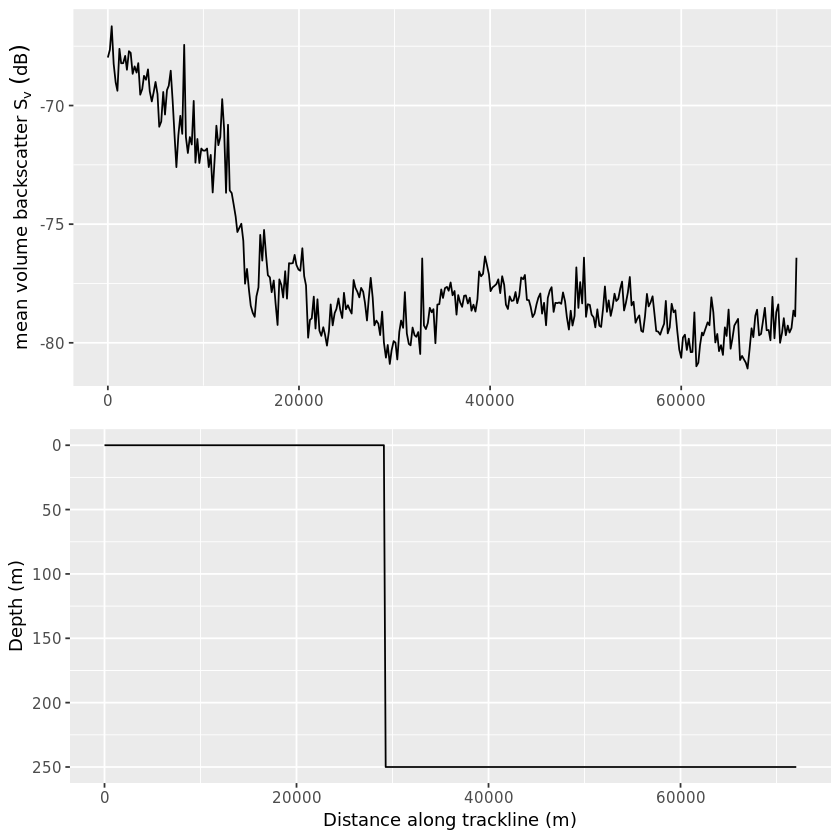

In [196]:
# Top panel - assign the Sv plot
Sv_mean_plot<- ggplot(data_sbf_full, aes(x=distalong, y=Sv_mean)) +
  geom_line() +
  labs(y=expression(mean~volume~backscatter~S[v]~(dB))) +
  theme(axis.title.x=element_blank())

# Bottom panel - assign the bathymetry plot
bthy <- ggplot(data_sbf_full, aes(x=distalong, y=depth_plot)) +
  geom_line(size = 0.5) +
  scale_y_reverse() +
  labs(x = "Distance along trackline (m)", y = "Depth (m)")

# Display the two panels in one figure
grid.arrange(Sv_mean_plot,bthy)

## 12. So, where are the fishes?
<p>Nice looking plot!</p>
<p>If we assume all the backscatter energy is only from fishes with swim bladders, and greater backscatter indicates more fish, where are most of the fish on this track line?</p>

In [198]:
# Where do you think the fish are along this track line?

# Options: Shelf, Shelf Break, Offshore

(where_are_the_fishes <- "Shelf")

[1] "Shelf"